In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
n2v_result_df = pd.concat([
    pd.read_csv('../result/tissue_gene_classification_n2v.csv'),
    pd.read_csv('../result/tissue_gene_classification_n2vplus.csv'),
]).reset_index()

optim_idx_ary = n2v_result_df.groupby(['Network', 'Method', 'Task'])['Validation score'].agg('idxmax').values
result_df = n2v_result_df.iloc[optim_idx_ary]

result_df = pd.concat(
    (
        result_df,
        # Extract tissue corresponding to tasks
        (
            result_df["Task"]
            .str.split("_GO:", expand=True)
            .rename(columns={0: "Task tissue", 1: "Task name"})
        ),
        # Extract tissue corresponding to networks
        (
            result_df["Network"]
            .str.split("-", expand=True)
            .rename(columns={0: "Network name", 1: "Network tissue"})
        ),
    ),
    axis=1,
)

result_df

,index,Training score,Validation score,Testing score,Task,Dataset,Network,Method,p,q,gamma,Task tissue,Task name,Network name,Network tissue
0,0,0.394292,0.502445,-0.008777,blood_GO:0001525,GOBP-tissue,GTExCoExp-blood,Node2vec,0.01,0.01,0.0,blood,0001525,GTExCoExp,blood
26,26,1.154335,1.381161,-0.282798,blood_GO:0001568,GOBP-tissue,GTExCoExp-blood,Node2vec,0.10,0.01,0.0,blood,0001568,GTExCoExp,blood
27,27,1.314415,0.896538,0.072529,blood_GO:0007596,GOBP-tissue,GTExCoExp-blood,Node2vec,0.10,0.01,0.0,blood,0007596,GTExCoExp,blood
28,28,0.749190,0.977819,0.146796,blood_GO:0030098,GOBP-tissue,GTExCoExp-blood,Node2vec,0.10,0.01,0.0,blood,0030098,GTExCoExp,blood
104,104,0.547821,1.335916,0.350392,blood_GO:0030099,GOBP-tissue,GTExCoExp-blood,Node2vec,1.00,0.01,0.0,blood,0030099,GTExCoExp,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20645,17145,2.908792,1.102378,1.934346,muscle_GO:0006937,GOBP-tissue,HumanBaseTop-muscle,Node2vec+,100.00,0.01,1.0,muscle,0006937,HumanBaseTop,muscle
20396,16896,3.136023,2.042553,-0.114875,muscle_GO:0016202,GOBP-tissue,HumanBaseTop-muscle,Node2vec+,0.01,0.01,1.0,muscle,0016202,HumanBaseTop,muscle
20397,16897,3.136023,2.042553,-0.114875,muscle_GO:0048634,GOBP-tissue,HumanBaseTop-muscle,Node2vec+,0.01,0.01,1.0,muscle,0048634,HumanBaseTop,muscle
20673,17173,1.082396,1.399873,1.039337,muscle_GO:0051147,GOBP-tissue,HumanBaseTop-muscle,Node2vec+,100.00,0.10,1.0,muscle,0051147,HumanBaseTop,muscle


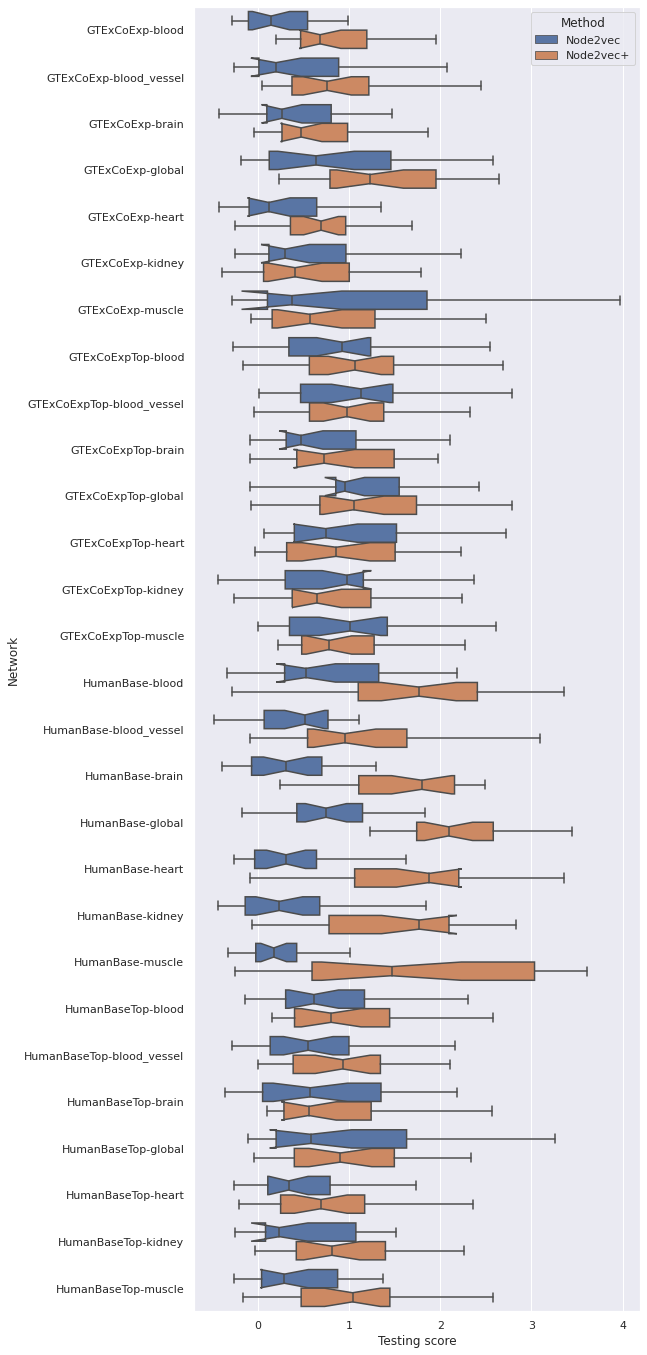

In [3]:
plt.figure(figsize=(8, 24))
sns.boxplot(data=result_df, y="Network", x="Testing score", hue="Method", notch=True, showfliers=False)
plt.show()

In [4]:
list(
    map(
        lambda x: "-".join(x).rstrip("-"),
        itertools.product(
            ["HumanBase", "HumanBaseTop", "GTExCoExp", "GTExCoExpTop"],  # list of networks
            ["", "other", "global"],  # variation of networks
        )
    )
)

['HumanBase',
 'HumanBase-other',
 'HumanBase-global',
 'HumanBaseTop',
 'HumanBaseTop-other',
 'HumanBaseTop-global',
 'GTExCoExp',
 'GTExCoExp-other',
 'GTExCoExp-global',
 'GTExCoExpTop',
 'GTExCoExpTop-other',
 'GTExCoExpTop-global']

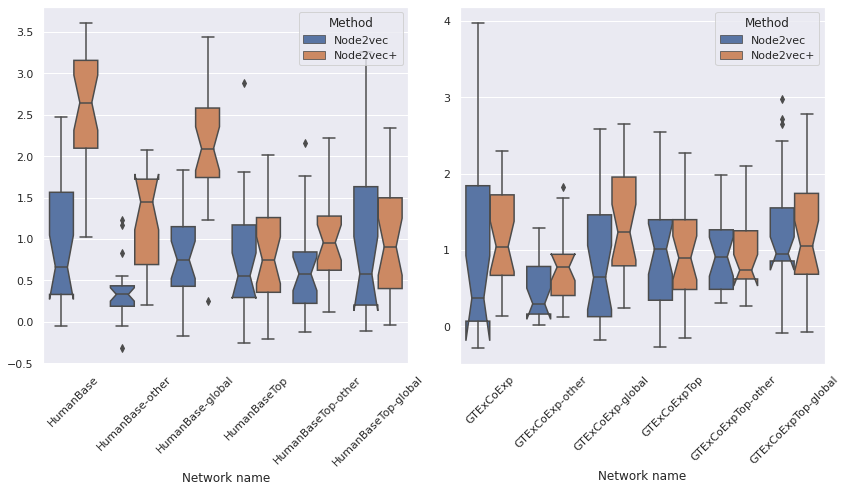

In [5]:
tissue_matched_result_df = pd.concat(
    (
        # Matched tissue
        result_df[result_df["Task tissue"] == result_df["Network tissue"]],
        # Other tissues (average)
        (
            result_df[
                (result_df["Task tissue"] != result_df["Network tissue"])
                & (result_df["Network tissue"] != "global")
            ]
            .groupby(
                ["Network name", "Task name", "Method"],
                as_index=False,
            )[["Training score", "Validation score", "Testing score"]]
            .mean()
            .replace(
                ["HumanBase", "HumanBaseTop", "GTExCoExp", "GTExCoExpTop"],
                ["HumanBase-other", "HumanBaseTop-other", "GTExCoExp-other", "GTExCoExpTop-other"],
            )
        ),
        # Tissue naive (global)
        (
            result_df[result_df["Network"].isin(["HumanBase-global", "HumanBaseTop-global",
                                                 "GTExCoExp-global", "GTExCoExpTop-global"])]
            .replace(
                ["HumanBase", "HumanBaseTop", "GTExCoExp", "GTExCoExpTop"],
                ["HumanBase-global", "HumanBaseTop-global", "GTExCoExp-global", "GTExCoExpTop-global"],
            )
        ),
    )
)

# Network orders
orders = [
    [
        "HumanBase",
        "HumanBase-other",
        "HumanBase-global",
        "HumanBaseTop",
        "HumanBaseTop-other",
        "HumanBaseTop-global",
    ],
    [
        "GTExCoExp",
        "GTExCoExp-other",
        "GTExCoExp-global",
        "GTExCoExpTop",
        "GTExCoExpTop-other",
        "GTExCoExpTop-global",
    ],
]

# Plot performance boxplots, split by network groups
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=False)
for ax, order in zip(axes, orders):
    sns.boxplot(
        data=tissue_matched_result_df,
        x="Network name",
        y="Testing score",
        order=order,
        hue="Method",
        notch=True,
        ax=ax,
    )
    ax.tick_params(axis="x", rotation=45)
    ax.set_ylabel("")

plt.tight_layout()
plt.show()